# Data Visualization

In [1]:
from pathlib import Path
import numpy as np 
import pandas as pd
import pickle

import matplotlib.pyplot as plt

from skimage import io

# tqdm is a library that enables you to visualize the progress of a for loop by displaying a configurable progress bar
from tqdm.notebook import tqdm
tqdm().pandas();

import seaborn as sns

0it [00:00, ?it/s]

# 1. Loading data

In [3]:
sample_df = pd.read_pickle(r"./data/images.pkl")

# 2. Displaying cancerous and healthy images

In [4]:
def display_patches(nrows, ncols, target, path_df):
    tissue_indices = np.random.choice(path_df[path_df['target']==target].index, size=nrows*ncols, replace=False)
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*6,nrows*6))
    for i,ax in enumerate(axes.flatten()):
        idx = tissue_indices[i]
        img = io.imread(path_df.loc[idx,'path'])
        ax.imshow(img)

### Cancerous patches

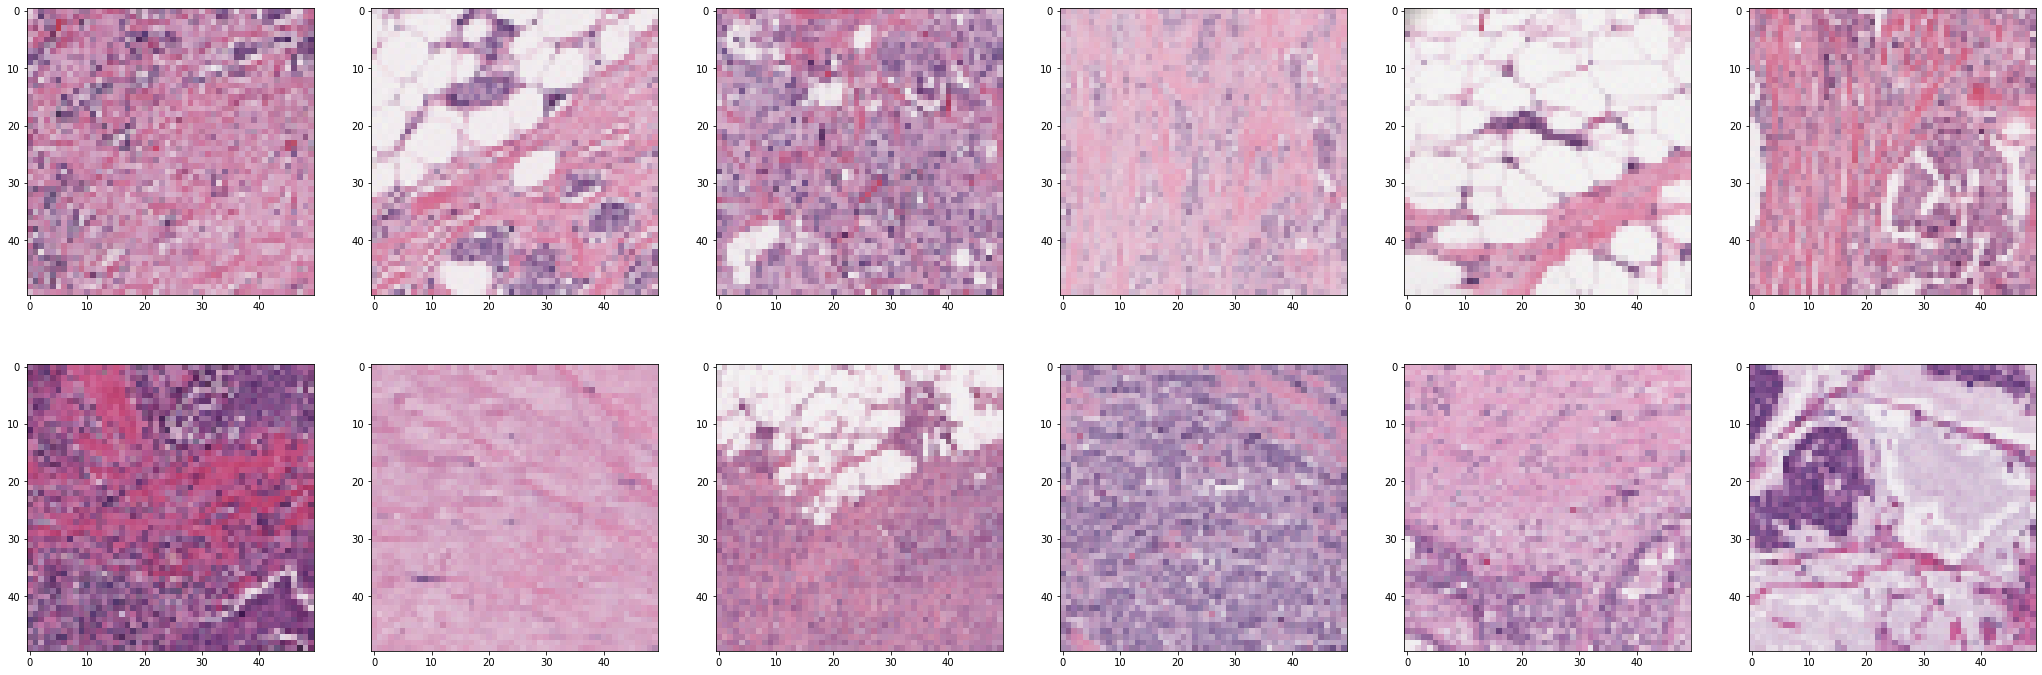

In [5]:
display_patches(nrows = 2, ncols = 6, target = 1, path_df = sample_df)

### Healthy patches

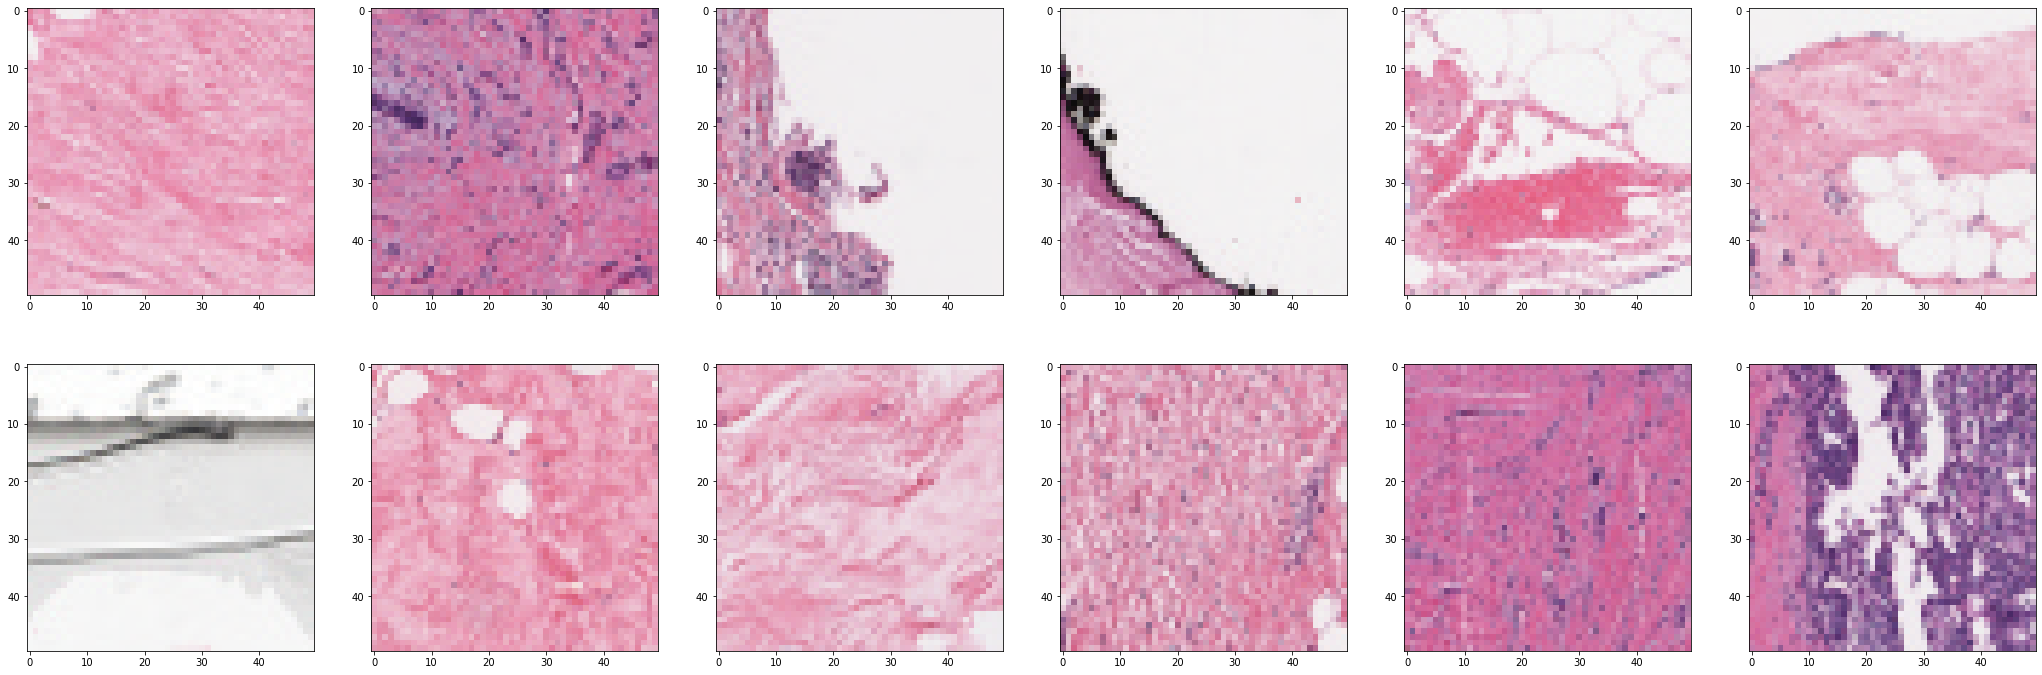

In [6]:
display_patches(nrows = 2, ncols = 6, target = 0, path_df = sample_df)

Cancerous patches look a little darker on average.

# 3. A look at cancer ratio and number of patches for each patient

In [7]:
# Function below gets the the number of patches for each patient, 
# and gets the ratio of cancerous patches to non-cancerous patches for each patient

def get_image_count_and_cancer_ratios_used(path_df):
    # Return the count of images per patient
    s1 = path_df.groupby('patient_id')['target'].count()
    # Return the ratio of cancerous to non-cancerous images per-patient
    s2 = path_df.groupby('patient_id')['target'].mean()

    # Merge the series into one dataframe that uses the same index
    df_summary = pd.concat([s1,s2],axis = 1)
    df_summary.columns = ['n_patches/patient','ratio of cancerous tissue']
    return df_summary

df_used = get_image_count_and_cancer_ratios_used(path_df = sample_df)
display(df_used)

,n_patches/patient,ratio of cancerous tissue
patient_id,,
8863,493,0.401623
8864,586,0.522184
8865,326,0.162577
8867,739,0.212449
8913,421,0.194774
...,...,...
16568,473,0.572939
16569,133,0.248120
16570,639,0.799687


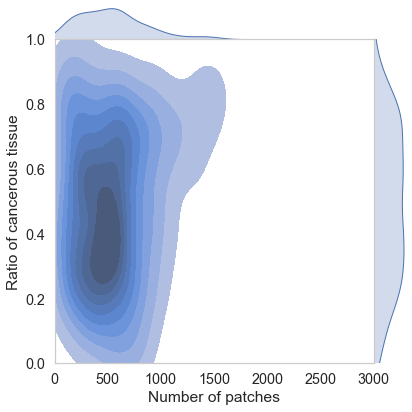

In [8]:
sns.set(font_scale = 1.3)
sns.set_style("whitegrid", {'axes.grid' : False})
jp = sns.jointplot(data=df_used, x="n_patches/patient", y="ratio of cancerous tissue", 
              kind="kde", fill = True, xlim = [0,3000], ylim = [0,1],
              ratio = 10, space = 0, marginal_ticks = False, palette = "mako"
             )
jp.set_axis_labels("Number of patches", "Ratio of cancerous tissue")

## 4. Visualizing whole breast tissue of a patient

In [9]:
def get_patient_df(p_id,df=sample_df):
    return df.loc[df['patient_id']== p_id,:] 

In [10]:
def get_tissue_image_array(patient_id,pred = False):
    # get patient dataframe
    path_df = get_patient_df(patient_id)
    # get the max_coordinate to define the numpy array size, numpy array will be containing the rgb values for the image
    max_coord = np.max((*path_df['x_coord'],*path_df['y_coord']))
    # add 50 to the max_coord to get the final image dimension,50 here is the patch size
    image_dimension = max_coord + 50
    # create a 3 dimensional array with RGB values = 255, we set the type as uint since no RGB value can be > 255, thus increasing efficiency
    grid = 255*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    for x,y,target,path in path_df[['x_coord','y_coord','target','path']].values:
        img_array = io.imread(path)
        # some patches have dimension less than 50 x 50 which would cause the code to break
        try:
            # replace values in grid array by the image array values
            grid[y:y+50,x:x+50] = img_array 
        except: pass
    img = grid

    return img
            

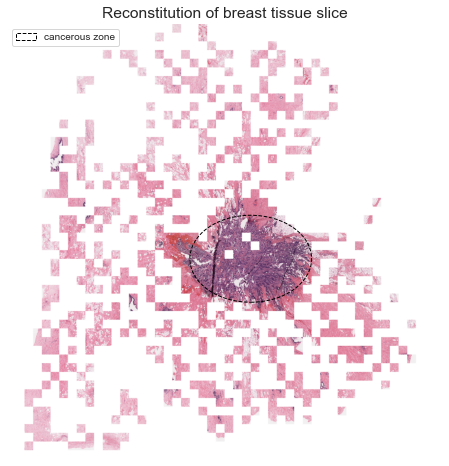

In [12]:
from matplotlib.patches import Ellipse

f, ax = plt.subplots(figsize=(8, 8))
img = get_tissue_image_array(12890)
plt.imshow(img)
plt.xlim(0,2500)
plt.ylim(0,2500)
#plt.xlabel("x")
#plt.ylabel("y")
plt.axis("off")
plt.title("Reconstitution of breast tissue slice")
plt.xticks([])
plt.yticks([])
ellipse = Ellipse(xy=(1400,1150), width=700, height=500, 
                        edgecolor='black', fc='None', lw=1, ls='--')
ax.add_patch(ellipse)
ellipse.set_label('cancerous zone')
ax.legend(loc = "upper left", fontsize = 10)
plt.show()

## 5. Analysis of color data

In [13]:
import colorsys

In [14]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [15]:
def convert_image_to_hls(img_rgb):
    img_hls = np.zeros(img_rgb.shape)
    for i in range(img_rgb.shape[0]):
        for j in range(img_rgb.shape[1]):
            hls_tuple = colorsys.rgb_to_hls(img_rgb[i,j,0]/255, img_rgb[i,j,1]/255, img_rgb[i,j,2]/255)
            img_hls[i,j,0] = hls_tuple[0]
            img_hls[i,j,1] = hls_tuple[1]
            img_hls[i,j,2] = hls_tuple[2]
    return img_hls
    
def convert_image_to_rgb(img_hls):
    img_rgb = np.zeros(img_hls.shape)
    for i in range(img_hls.shape[0]):
        for j in range(img_hls.shape[1]):
            rgb_tuple = colorsys.hls_to_rgb(img_hls[i,j,0], img_hls[i,j,1], img_hls[i,j,2])
            img_rgb[i,j] = [int(255*rgb_tuple[0]), int(255*rgb_tuple[1]), int(255*rgb_tuple[2])]
    return img_rgb.astype(int)

In [16]:
def draw_random_kernel(size, path_df = sample_df):
    # getting the random samples paths
    cancerous_rgb_path = np.random.choice(path_df[path_df['target']==1].index, size=size, replace=False)
    no_cancerous_rgb_path = np.random.choice(path_df[path_df['target']==0].index, size=size, replace=False)

    # getting the images
    cancerous_rgb = [io.imread(path_df.loc[idx,'path']) for idx in cancerous_rgb_path]
    no_cancerous_rgb = [io.imread(path_df.loc[idx,'path']) for idx in no_cancerous_rgb_path]

    # converting the RGB imgs to HLS
    cancerous_hls = np.array([convert_image_to_hls(img) for img in cancerous_rgb])
    no_cancerous_hls = np.array([convert_image_to_hls(img) for img in no_cancerous_rgb])

    # getting the LS coordinates for our plot
    cancerous_LS = np.array([[cancerous_hls[u,i,j,1] , cancerous_hls[u,i,j,2]] for u in range(cancerous_hls.shape[0]) for i in range(cancerous_hls.shape[1]) for j in range(cancerous_hls.shape[2])])
    no_cancerous_LS = np.array([[no_cancerous_hls[u,i,j,1] , no_cancerous_hls[u,i,j,2]] for u in range(no_cancerous_hls.shape[0]) for i in range(no_cancerous_hls.shape[1]) for j in range(no_cancerous_hls.shape[2])])


    # plotting the kernel
    f, ax = plt.subplots(figsize=(8, 8))
    background_x = np.linspace(0,1,100)
    background_y = np.linspace(1,0,100)
    H = np.mean(cancerous_hls[:,:,:,0].flatten())
    background = np.array([[[H, x, y] for x in background_x] for y in background_y])
    background_rgb = convert_image_to_rgb(background)
    plt.imshow(background_rgb, extent=[0, 1, 0, 1])
    sns.kdeplot(x=cancerous_LS[:,0], y=cancerous_LS[:,1], fill=False, levels = 10, cut = 3, color = "black", linewidths = 1, label = "cancerous")
    sns.kdeplot(x=no_cancerous_LS[:,0], y=no_cancerous_LS[:,1], fill=False, levels = 10, cut = 3, color = "white", linewidths = 1, label = "healthy")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("Lightness")
    plt.ylabel("Saturation")
    plt.legend(loc = "upper left")
    plt.title("Kernel density of tissue color")
    plt.show()

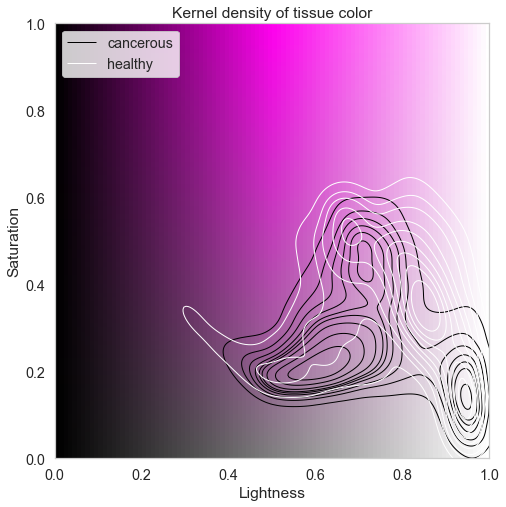

In [21]:
draw_random_kernel(size = 5)

The kernel lines shed into light the darker color of the cancerous tissue on average.